# Advanced Lane Finding

#### Steps followed here
##### 1) Calibrate the camera and get camera matrix and distortion coefficients
##### 2) Using camera matrix and distortion coefficients get undistorted image
##### 3) On undistorted images apply color transform and/or gradient to extract lanes features and get binary image which should mostly contain lanes features.
##### 4) Do perspective transform on the binary image to get bird eye view. Let’s call resulting image binary wrapped image
##### 5) Use histogram and sliding window technique on binary wrapped image to get lane pixels.
##### 6) find best fit second-degree polynomial to fit left and right lane lines pixels.
##### 7) Transform detected left and right lane lines to original image.
##### 8) from left and right line curves, find average radius of curvature.
##### 9) assuming camera is centered in the image find car position with in the lane.

#### Detailed description is below with each step.
## =========================================================================

### Include required python modules

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
from moviepy.editor import VideoFileClip
#%matplotlib qt
%matplotlib inline

### Add the required function that are used, Some of them are taken from the previous lessons

In [2]:
# This function is slight modified from the lesson. It takes image file name list, rows and colomns of corners
def calibrateCameraWithImages(images, nx, ny):
    """This function takes image file names as input and returns camera matrix and distortion coefficients"""
    # common object points, true for all calibration images
    object_points = np.zeros((6*9,3), np.float32)
    object_points[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    # array of object points, to store for all callibration images
    object_points_array = []
    # same for image points
    image_points_array = []
    for file_name in images:
        image = cv2.imread(file_name)
        gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray_image, (nx, ny), None)
        if ret == True:
            image_points_array.append(corners)
            object_points_array.append(object_points)
    
    # get the first image to get the size
    image_shape = cv2.cvtColor(cv2.imread(images[0]),cv2.COLOR_BGR2GRAY).shape
    return cv2.calibrateCamera(object_points_array, image_points_array, image_shape[::-1], None, None)

def seperateIn3(image_3):
    """This function returns 3 different images of 3d image. for example rgb, bgr, hsl etc.."""
    return image_3[:,:,0], image_3[:,:,1], image_3[:,:,2]

def binaryWithOneThresold(image_1, thresold):
    """This function returns binary image if any pixel value of image_1 lies between threshold boundaries"""
    binary = np.zeros_like(image_1)
    binary[(image_1 >= thresold[0]) & (image_1 <= thresold[1])] = 1
    return binary

def binaryOr(image_1, image_2):
    """This function returns OR of image_1 and image_2"""
    binary = np.zeros_like(image_1)
    binary[(image_1 == 1) | (image_2 == 1)] = 1
    return binary

def gradientThresholdX(image_1, sobel_kernel=3, threshold=[0, 255]):
    """This function applies sobelX gradient on image_1 and returns binary image according to threshold"""
    sobelx = cv2.Sobel(image_1, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    return binaryWithOneThresold(scaled_sobel, threshold)

def gradientThresholdY(image_1, sobel_kernel=3, threshold=[0, 255]):
    """This function applies sobelY gradient on image_1 and returns binary image according to threshold"""
    sobely = cv2.Sobel(image_1, cv2.CV_64F, 0, 1)
    abs_sobely = np.absolute(sobely)
    scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    return binaryWithOneThresold(scaled_sobel, threshold)

def get_binary(image_rgb):
    """This is the acutal function used to get binary image. A RGB image is transformed in HLS and then R and S 
    values are being seperated. On both gradient sobel X is applied and different binaries are being generated.
    final result is OR of S and R binary images"""
    gradient_S_X_thresold = [20,100]
    gradient_R_X_thresold = [80,120]
    
    hls_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HLS)
    h, l, s = seperateIn3(hls_image)
    s_x_binary = gradientThresholdX(s, 9, gradient_S_X_thresold)
    
    r,g,b = seperateIn3(image_rgb)
    r_x_binary = gradientThresholdX(r, 9, gradient_R_X_thresold)
      
    return cv2.bitwise_or(s_x_binary, r_x_binary)
    

def mask_with_ROI(src_points, binary):
    """This function masks binary image with a polygon created by src_points"""
    mask = np.zeros_like(binary)
    vertices = np.array([[src_point_1, src_point_2, src_point_3, src_point_4]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, 255)
    return cv2.bitwise_and(binary, mask)


def get_perspective_transform(src_points, dest_points):
    """This function returns perspective transform and inverse"""
    perspet_transpose = cv2.getPerspectiveTransform(src_points, dest_points)
    perspet_transpose_inverse = cv2.getPerspectiveTransform(dest_points, src_points)
    return perspet_transpose, perspet_transpose_inverse


# This function is taken from lessons
def find_lane_pixels(binary_warped):
    """get the histogram for bottom of the image. Usually bottom of the image is more clear.
    find left and right peaks of the histogram. these will be lane line pixel at the bottom of the image
    decide the no of windows (9). loop over each window to get lane pixels. minpix is the parameter to 
    move the vertical window, if pixel found in peak histogram are more then minpix then only select it, otherwise 
    keep using previous on for poly fitting"""
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    # y means rows x means colomn
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & 
                          (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  
                          (nonzerox < win_xleft_high)).nonzero()[0]

        good_right_inds = ((nonzeroy >= win_y_low) & 
                           (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  
                           (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

# This function is taken from the lessons
def fit_polynomial(leftx, lefty, rightx, righty):
    """Fit a second order polynomial to each using `np.polyfit`"""
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

# This functin is taken from the lessons
def search_around_poly(binary_warped, left_fit, right_fit):
    """Instead of searching lane lines from scratch this function searches lane lines
    around left_fit and right_fit polynomials with a margin"""
    
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty


def find_lane_lines_wrapped(binarywrapped, left_fit= None, right_fit=None):
    """This function finds lanes on binary wrapped image either from scratch or
    around left and right polynomials"""
    leftx = []
    lefty = []
    rightx = []
    righty = []
    
    if (left_fit is None) or (right_fit is None):
        leftx, lefty, rightx, righty = find_lane_pixels(binarywrapped)
    else:
        leftx, lefty, rightx, righty = search_around_poly(binarywrapped, left_fit, right_fit)
    
    left_fit, right_fit = fit_polynomial(leftx, lefty, rightx, righty)
    
    return left_fit, right_fit, leftx, lefty, rightx, righty    

# This function is used from previous lessons
def project_lanes_back(original, warped, left_fit, right_fit, Minv):
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original.shape[1], original.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original, 1, newwarp, 0.3, 0)
    return result

    
def validate_line(left_fit, right_fit, left_fit_x, left_fit_y, right_fit_x, right_fit_y):
    """This function tries to valide if detected lane is valid or not. It can be improved"""    
    if((len(left_fit) != 3) or (len(right_fit) != 3)):
        return False
    else:
        if len(left_fit_x) < 100:
            return False
        else:
            return True
            


def create_region_of_interest():
    """This funciton creates a region of interest (ROI). We only check for lanes in this ROI"""
    src_point_1 = (570,460) # top left corner
    src_point_2 = (190,720) # bottom left corner
    src_point_3 = (1220, 710) # bottom right corner
    src_point_4 = (715,460) # top right corner
    return np.float32([src_point_1, src_point_2, src_point_3, src_point_4])

def get_perspective_transform_high(image_shape):
    """This function creates source points and destination points.
    Then it gets perspective transform and inverse"""
    src_point_1 = (585,460) # top left corner
    src_point_2 = (203,720) # bottom left corner
    src_point_3 = (1127, 710) # bottom right corner
    src_point_4 = (695,460) # top right corner
    src_points = np.float32([src_point_1, src_point_2, src_point_3, src_point_4])
    
    dest_point_1 = (320,0)
    dest_point_2 = (320, 720)
    dest_point_3 = (960, 720)
    dest_point_4 = (960, 0)
    dest_points = np.float32([dest_point_1, dest_point_2, dest_point_3, dest_point_4])
    
    perspet_transpose, perspet_transpose_inverse = get_perspective_transform(src_points, dest_points)
    
    return perspet_transpose, perspet_transpose_inverse
    
    
def get_binary_wrapped_image(binary_image, perspet_transpose, image_shape):
    """For a binary image, does perspective transform and return wrapped image"""
    return cv2.warpPerspective(binary_image, perspet_transpose, image_shape, flags=cv2.INTER_LINEAR)

# This function is taken from the previous lessons
def calc_car_pos(img_shape, left_fit, right_fit):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Assuming camera is centered in the image, return position of car in cms.
    car_loc = img_shape[1] / 2

    # Find lane line bottom x-corrdinate
    height = img_shape[0]
    bottom_left = left_fit[0]*height**2 + left_fit[1]*height + left_fit[2]
    bottom_right = right_fit[0]*height**2 + right_fit[1]*height + right_fit[2]

    center_lane = (bottom_right - bottom_left)/2 + bottom_left 
    center_offset = ( np.abs(car_loc) - np.abs(center_lane)) * xm_per_pix * 100
    return center_offset

# This function is taken from the previous lessons
def measure_curvature_real(ploty, leftx, lefty, rightx, righty):
    """Calculates the curvature of polynomial functions in meters."""
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad


def average_line(left_line_list, right_line_list, elements):
    """This function returns average of left and right curves"""
    i = len(left_line_list)-1
    count = 0.0
    left_line_average=[]
    right_line_average=[]
    
    left_line_average.append(0.0); left_line_average.append(0.0); left_line_average.append(0.0);
    right_line_average.append(0.0); right_line_average.append(0.0); right_line_average.append(0.0);
    
    while(i >= 0 and count < elements):
        left_line_average[0] = left_line_average[0] + left_line_list[i][0]
        left_line_average[1] = left_line_average[1] + left_line_list[i][1]
        left_line_average[2] = left_line_average[2] + left_line_list[i][2]
        
        right_line_average[0] = right_line_average[0] + right_line_list[i][0]
        right_line_average[1] = right_line_average[1] + right_line_list[i][1]
        right_line_average[2] = right_line_average[2] + right_line_list[i][2]
        
        i-=1
        count+=1
        
    left_line_average[0] = left_line_average[0] / count
    left_line_average[1] = left_line_average[1] / count
    left_line_average[2] = left_line_average[2] / count
        
    right_line_average[0] = right_line_average[0] / count
    right_line_average[1] = right_line_average[1] / count
    right_line_average[2] = right_line_average[2] / count
    
    return left_line_average, right_line_average


# class to store left and right line information in different iterations
class Line():
    def __init__(self):
        self.init = False  # indicate to search from scratch or search around already found lanes
        self.left_fit = [] # most recent coefficients of left lane polynomial
        self.right_fit = [] # most recent coefficients of right lane polynomial   
        self.left_fit_list = [] # past list of coefficients of left lane polynomial
        self.right_fit_list = [] # past list of coefficients of right lane polynomial
        self.search_average_left_fit = [] # average coefficients of last n(parameter) left lane polynomial for search
        self.search_average_right_fit = [] # average coefficients of last n(parameter) right lane polynomial for search
        self.draw_average_left_fit = [] # average coefficients of last n(parameter) left lane polynomial for draw
        self.draw_average_right_fit = [] # average coefficients of last n(parameter) left lane polynomial for draw
        self.left_fit_x =  [], # most recent x values of left lane pixels
        self.left_fit_y = [], # most recent y values of left lane pixels
        self.right_fit_x = [], # most recent x values of right lane pixels
        self.right_fit_y = [], # most recent y values of right lane pixels
        self.left_curvature = 0.0, # left lane radius of curvature
        self.right_curvature = 0.0 # right lane radius if curvature
        
        
def update_line_image(image_rgb, binary_wrapped_image, perspet_transpose_inverse, 
                      left_fit, right_fit, left_fit_x, left_fit_y, right_fit_x, right_fit_y):
    """This function updates Line object after successful iteration of finding lanes.
    It also draws found lanes and return resulting image with radius of curvature and car position
    info written"""
    line.init = True
    line.left_fit = left_fit
    line.right_fit = right_fit
    line.left_fit_x = left_fit_x
    line.left_fit_y = left_fit_y
    line.right_fit_x = right_fit_x
    line.right_fit_y = right_fit_y
    line.left_fit_list.append(left_fit)
    line.right_fit_list.append(right_fit)
    
    line.search_average_left_fit, line.search_average_right_fit = average_line(line.left_fit_list, line.right_fit_list, 10)
    line.draw_average_left_fit, line.draw_average_right_fit = average_line(line.left_fit_list, line.right_fit_list, 5)
    
    result = project_lanes_back(image_rgb, binary_wrapped_image, 
                                line.draw_average_left_fit, line.draw_average_right_fit, perspet_transpose_inverse)
    left_curvature, right_curvature = measure_curvature_real(np.linspace(0, binary_wrapped_image.shape[0]-1, binary_wrapped_image.shape[0]), 
                                                     line.left_fit_x, line.left_fit_y, line.right_fit_x, line.right_fit_y)
    pos_offset = calc_car_pos(image_rgb.shape, line.left_fit, line.right_fit)
    
    cv2.putText(result,'Radius: '+str((left_curvature + right_curvature)/2)+' m',(50,70), cv2.FONT_HERSHEY_SIMPLEX, 1.6,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Pos Offset: '+str(pos_offset)+' cm',(50,160), cv2.FONT_HERSHEY_SIMPLEX, 1.6,(255,255,255),2,cv2.LINE_AA)
    
    return result


def find_lane_pipe_line(image):
    """This is the main function which takes original RGB image and returns image with detected lanes and 
    radius of curvature and car position"""
    image_rgb = image.copy()
    result = image_rgb; 
    undist_image_rgb = cv2.undistort(image_rgb, mtx, dist, None, mtx)
    binary_image = get_binary(undist_image_rgb)
    
    image_shape = undist_image_rgb.shape[::-1][1:]
    perspet_transpose, perspet_transpose_inverse = get_perspective_transform_high(image_shape)
    binary_wrapped_image = get_binary_wrapped_image(binary_image, perspet_transpose, image_shape)
    
    left_fit = []  # left line polynomial curve coefficients
    right_fit = [] # right line polynomial curve coefficients
    left_fit_x = [] # left line pixels x values
    left_fit_y = [] # left line pixels y values
    right_fit_x = [] # right line pixels x values
    right_fit_y = [] # right line pixels y values
    
    if line.init is False:
        left_fit, right_fit, left_fit_x, left_fit_y, right_fit_x, right_fit_y = find_lane_lines_wrapped(binary_wrapped_image)
        if validate_line(left_fit, right_fit, left_fit_x, left_fit_y, right_fit_x, right_fit_y) is True:
            result = update_line_image(image_rgb, binary_wrapped_image, perspet_transpose_inverse, left_fit, right_fit, left_fit_x, left_fit_y, right_fit_x, right_fit_y)
    else:
        left_fit, right_fit, left_fit_x, left_fit_y, right_fit_x, right_fit_y = find_lane_lines_wrapped(binary_wrapped_image, line.search_average_left_fit, line.search_average_right_fit)
        if validate_line(left_fit, right_fit, left_fit_x, left_fit_y, right_fit_x, right_fit_y) is True:
            result = update_line_image(image_rgb, binary_wrapped_image, perspet_transpose_inverse, left_fit, right_fit, left_fit_x, left_fit_y, right_fit_x, right_fit_y)            
        else :
            line.init = False
            # clear past data
            line.left_fit_list = []
            line.right_fit_list = []
    return result


## Step 1: Camera Callibration.
##### There are 20 calibration images, provided. So open these images one by one and find chess board corners. Then use calibrateCamera to find "camera matrix" and "distortion coefficients". 
##### At last use "camera matrix" and "distortion coefficients" to find undistorted image

In [3]:
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
nx = 9
ny = 6
ret, mtx, dist, rvecs, tvecs = calibrateCameraWithImages(images,nx,ny)

### rubric point 1 Camera Calibration
 #### 1) read all the calibration images
 #### 2) for each one find corners, append them in a list. (calling image points).
 #### 3) for each image append object points in a list. (calling object points, same for all callibration images)
 #### 4) using object points and image points, call cv2.calibrateCamera function to get camera matrix and distortion coefficients
 #### 5) now use cv2.undistort function to get undistorted image
 #### 6) plot it

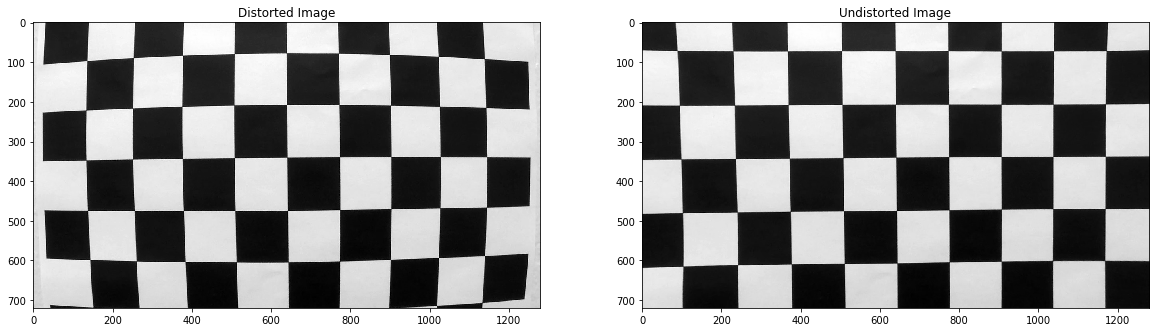

In [4]:
# rubric point 1 showing 
# check undistored image
frame, axis_array = plt.subplots(1, 2)
frame.set_size_inches(20, 20)

cal_img = cv2.imread('camera_cal/calibration1.jpg')
cal_gray = cv2.cvtColor(cal_img,cv2.COLOR_BGR2GRAY)
cal_undist = cv2.undistort(cal_gray, mtx, dist, None, mtx)
axis_array[0].set_title("Distorted Image")
axis_array[1].set_title("Undistorted Image")
axis_array[0].imshow(cal_gray, cmap = "gray")
axis_array[1].imshow(cal_undist, cmap = "gray")

cv2.imwrite('output_images/rubric_1_cal_gray.png',cal_gray)
cv2.imwrite('output_images/rubric_1_cal_undist.png',cal_undist)

plt.show()

## Pipeline (test images)

### Rubric point 2 (Provide an example of a distortion-corrected image.)
#### 1) using camera matrix and distortion coefficients, call cv2.undistort function to get undistorted image
#### 2) plot it.

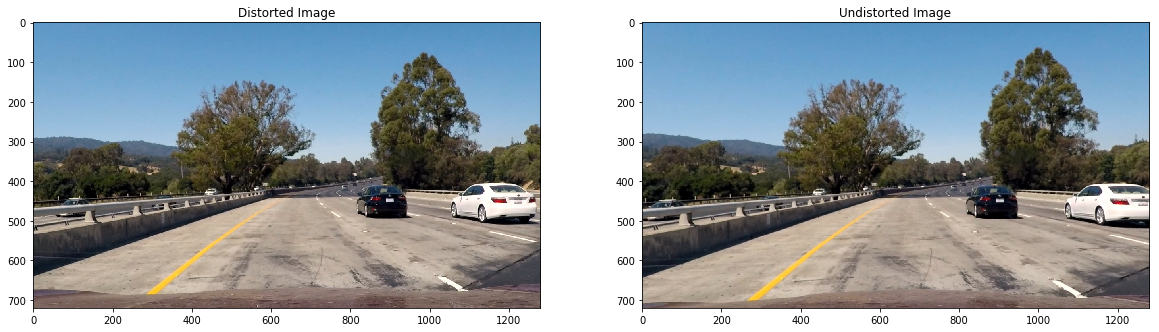

In [5]:
# rubric point 2
# check undistored image
frame, axis_array = plt.subplots(1, 2)
frame.set_size_inches(20, 20)

test_image = cv2.imread('test_images/test1.jpg')
rgb_test_image = cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)
undist_test_image = cv2.undistort(rgb_test_image, mtx, dist, None, mtx)
axis_array[0].set_title("Distorted Image")
axis_array[1].set_title("Undistorted Image")
axis_array[0].imshow(rgb_test_image)
axis_array[1].imshow(undist_test_image)

cv2.imwrite('output_images/rubric_2_rgb_test_image.png', cv2.cvtColor(rgb_test_image, cv2.COLOR_RGB2BGR))
cv2.imwrite('output_images/rubric_2_undist_test_image.png', cv2.cvtColor(undist_test_image, cv2.COLOR_RGB2BGR))

plt.show()

### Rubric point 3 (getting binary image using color transforms and gradients)
#### 1) get r,g,b and h,l,s images
#### 2) s and r value image is found to be more suitable, so it is used to detect yellow and white lane lines.
#### 3) get sobel X gredient for both S and R images and OR them. This is the final binary image which contains lane features

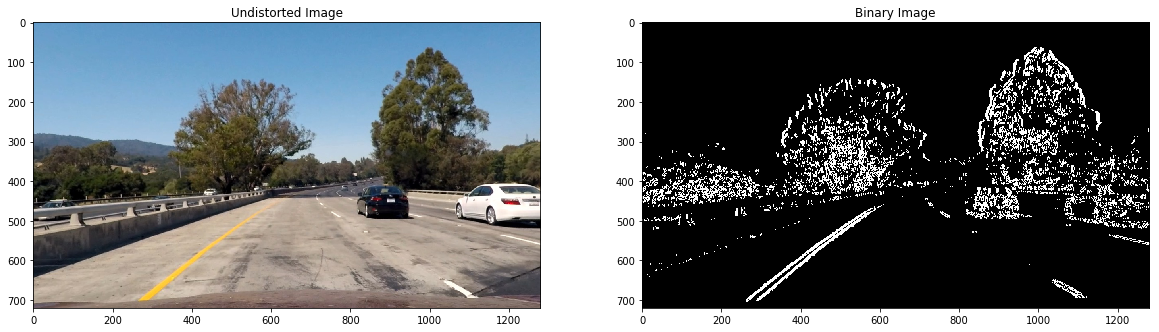

In [6]:
binary_image = get_binary(undist_test_image)

frame, axis_array = plt.subplots(1, 2)
frame.set_size_inches(20, 20)
axis_array[0].set_title("Undistorted Image")
axis_array[1].set_title("Binary Image")
axis_array[0].imshow(undist_test_image)
axis_array[1].imshow(binary_image, cmap = "gray")

cv2.imwrite('output_images/rubric_3_undist_test_image.png', cv2.cvtColor(undist_test_image, cv2.COLOR_RGB2BGR))
cv2.imwrite('output_images/rubric_3_binary_image.png', binary_image.astype('uint8') * 255)

plt.show()

### Rubric Point 4 perspective transform 
#### 1) using cv2.getPerspectiveTransform get perspective_transform matrix
#### 2) choose source points (4) in original image and destination points (4) in resulting image to get birds eye view image.
#### 3) apply perspective transform matrix and plot resulting image

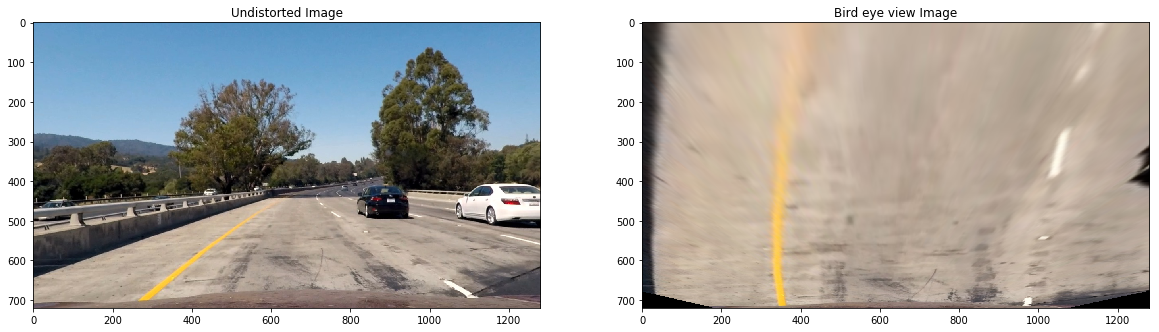

In [7]:
image_shape = undist_test_image.shape[::-1][1:]
perspet_transpose, perspet_transpose_inverse = get_perspective_transform_high(image_shape)
p_trans_test_image = cv2.warpPerspective(undist_test_image, perspet_transpose, image_shape, flags=cv2.INTER_LINEAR)

frame, axis_array = plt.subplots(1, 2)
frame.set_size_inches(20, 20)
axis_array[0].set_title("Undistorted Image")
axis_array[1].set_title("Bird eye view Image")
axis_array[0].imshow(undist_test_image)
axis_array[1].imshow(p_trans_test_image)

cv2.imwrite('output_images/rubric_4_undist_test_image.png', cv2.cvtColor(undist_test_image, cv2.COLOR_RGB2BGR))
cv2.imwrite('output_images/rubric_4_p_trans_test_image.png', cv2.cvtColor(p_trans_test_image, cv2.COLOR_RGB2BGR))

plt.show()

### Rubric Point 5 (Identify lane-line pixels and fit their positions with a polynomial)
#### 1) First apply bird eye view transform to binary image that we got in previous steps.
#### 2) Call find_laen_lines_wrapped function to get left/right_fit polynomials with left/right_fit_X/Y pixels. 
#### 3) To plot resulting lane line polynomials and pixels, create 3d image from binary_wrapped_image, using np.dstak
#### 4) for every Y pixel value, get X pixel value from left and right polynomials
#### 5) Add margin(100) around these pixels and draw them in green color
#### 6) draw left/right_fit_x/y pixels also which we got from sliding window technique

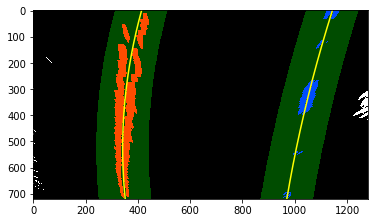

In [8]:
binary_wrapped_image = get_binary_wrapped_image(binary_image, perspet_transpose, image_shape)
left_fit, right_fit, left_fit_x, left_fit_y, right_fit_x, right_fit_y = find_lane_lines_wrapped(binary_wrapped_image)

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_wrapped_image, binary_wrapped_image, binary_wrapped_image))*255
window_img = np.zeros_like(out_img)
margin = 100
# Generate x and y values for plotting
ploty = np.linspace(0, binary_wrapped_image.shape[0]-1, binary_wrapped_image.shape[0] )
try:
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
except TypeError:
    # Avoids an error if `left` and `right_fit` are still none or incorrect
    print('The function failed to fit a line!')
    left_fitx = 1*ploty**2 + 1*ploty
    right_fitx = 1*ploty**2 + 1*ploty

## Visualization ##
# Colors in the left and right lane regions
out_img[left_fit_y, left_fit_x] = [255, 0, 0]
out_img[right_fit_y, right_fit_x] = [0, 0, 255]

# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

cv2.imwrite('output_images/rubric_5_result.png', cv2.cvtColor(result, cv2.COLOR_RGB2BGR))

plt.imshow(result)
plt.show()

## Rubric Point 6 (curvature of the lane and the position of the vehicle)
#### 1) From previous step we have left/right_fit_x/y pixels (sliding window technique)
#### 2) But these lane points are in pixel space. So they are converted to real world space and different polynomial was fitted for them.
#### 3) from polynomial coefficients calucate the left and right radius of curvature. print the average result.
#### 4) Assuming camera is centered in the image, So middle X pixel (column) of the whole image is the position of the car.
#### 5) Get bottom left/right X pixel for left/right lane lines
#### 6) Get middle of the lane X pixel value
#### 7) Differenec between 4 and 6 is car position in the lane, But it is in pixels. 
#### 8) Assuming lane width is 3.7 meters and lane is spread to 700 pixels then we can convert pixel to cm by multiplying 370/700 factor
#### 9) print car position in cm

In [9]:
left_curvature, right_curvature = measure_curvature_real(np.linspace(0, binary_wrapped_image.shape[0]-1, binary_wrapped_image.shape[0]), 
                                                     left_fit_x, left_fit_y, right_fit_x, right_fit_y)
pos_offset = calc_car_pos(test_image.shape, left_fit, right_fit)

print("radius of curavture in meter = ", (left_curvature+right_curvature)/2)
print("pos offset in cm = ", pos_offset)

radius of curavture in meter =  1117.45683952
pos offset in cm =  -10.9336318699


## Rubric Point 7 (result plotted back and lane area is identified clearly)
#### 1) From the previous step we already have all the information about left and right lines.
#### 2) call the function project_lanes_back()
#### 3) This function gets X pixel values for every Y pixel (zero to the size) from left_fit/right_fit polynomial, and draws it green.
#### 4) Finally It combines original image with drawn lanes image(previous step) to get resulting output.

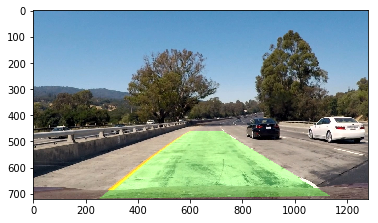

In [10]:
result = project_lanes_back(rgb_test_image, binary_wrapped_image, left_fit, right_fit, perspet_transpose_inverse)

cv2.imwrite('output_images/rubric_7_result.png', cv2.cvtColor(result, cv2.COLOR_RGB2BGR))

plt.imshow(result)
plt.show()

## Rubric Point 8 (Pipeline (video))
#### 1) Created an object of Line class to store left and right line information among differeent iteration of the video.
#### 2) Call the pipe line function (find_lane_pipe_line) for each image of the video
#### 3) Save newly created video with file name project_video_output.mp4

In [11]:
line = Line()
clip = VideoFileClip("project_video.mp4")
new_clip = clip.fl_image(find_lane_pipe_line)
new_clip.write_videofile("project_video_output.mp4", audio=False);

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [05:27<00:00,  3.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

